In [1]:
import polars as pl
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

plt.rcParams["font.family"] = "Hiragino Sans"


# JSONファイルの読み込み
files = glob.glob("jsons/*.json")
data_list = []

for file in files:
    with open(file, "r", encoding="utf-8") as f:
        json_data = json.load(f)
        market_date = json_data["market_condition"]["date"]
        shipped_volume = json_data["market_condition"]["shipped_volume"]

        for price_entry in json_data["prices"]:
            price_entry["date"] = market_date
            price_entry["shipped_volume"] = shipped_volume
            if price_entry["price_high"] == 0.0:
                price_entry["price_high"] = price_entry["price_low"]
            data_list.append(price_entry)

# PolarsのDataFrameに変換
df_polar = pl.DataFrame(data_list, infer_schema_length=1000)

In [2]:
df_polar = df_polar.sort('date')

In [3]:
# 統計情報の表示
df_polar.describe()

statistic,tree_species,diameter_class,length,top_diameter_min,top_diameter_max,price_low,price_middle,price_high,tone,summary,date,shipped_volume
str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64
"""count""","""8348""","""8348""",8348.0,8348.0,8348.0,8348.0,253.0,8348.0,"""120""","""267""","""8348""",8348.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,8095.0,0.0,"""8228""","""8081""","""0""",0.0
"""mean""",null,null,4.252911,18.272305,162.295352,17073.991375,17555.335968,21875.578462,null,null,null,1324.535577
"""std""",null,null,1.514895,22.113171,10950.152881,14179.320147,9533.717378,19001.538284,null,null,null,685.527737
"""min""","""その他""","""その他""",-1.0,-1.0,-1.0,0.0,0.0,-1.0,"""light""","""3m×16~18~20㎝は高値。""","""1993-07-06""",0.0
"""25%""",null,null,4.0,16.0,20.0,11000.0,11500.0,14000.0,null,null,null,850.0
"""50%""",null,null,4.0,16.0,20.0,13000.0,15000.0,18000.0,null,null,null,1200.0
"""75%""",null,null,4.3,24.0,26.0,20000.0,20500.0,25000.0,null,null,null,1670.0
"""max""","""モミ""","""長木""",100.0,1000.0,1e6,400000.0,90000.0,500000.0,"""高値""","""４ｍ、６ｍ共""","""2025-02-06""",12000.0


In [4]:
df = df_polar.to_pandas()

In [5]:
df[df['tree_species'] == '元木良材']

,tree_species,diameter_class,length,top_diameter_min,top_diameter_max,price_low,price_middle,price_high,tone,summary,date,shipped_volume


In [6]:
df['diameter_class'].unique()

array(['中目', '柱', '土台', '上物', '並材', '丁物', '登り', '長木', '上台', 'その他', '元木良材'],
      dtype=object)

In [7]:
# スギとヒノキのみを抽出
df = df[df['tree_species'].isin(['スギ', 'ヒノキ'])]
df = df[~df['diameter_class'].isin(['元木良材', 'その他'])]  #  '元木良材' と 'その他' を除く

# XGBoost

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ===========================================
# 2) 前処理・欠損処理
# ===========================================
# (A) price_low, price_high が欠損の行を除外
df = df.dropna(subset=['price_low', 'price_high'])

# (B) 日付を datetime 型に変換して年・月を作成 (季節性の特徴量)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# 必要に応じて日付が NaT になった行を除外
df = df.dropna(subset=['year', 'month'])

# =======================
# 2) Lag特徴量の作成
# =======================
# 例えば、過去3ヶ月の価格を特徴量として利用
df["price_low_lag_1"] = df["price_low"].shift(1)
df["price_low_lag_2"] = df["price_low"].shift(2)
df["price_high_lag_1"] = df["price_high"].shift(1)
df["price_high_lag_2"] = df["price_high"].shift(2)

# Lagデータは最初の2行が NaN になるので削除
df = df.iloc[2:]

# =======================
# 3) 特徴量とターゲット設定
# =======================
num_cols = ["length", "top_diameter_min", "top_diameter_max",
            "shipped_volume", "year", "month",
            "price_low_lag_1", "price_low_lag_2",
            "price_high_lag_1", "price_high_lag_2"]
cat_cols = ['tree_species', 'diameter_class']

X = df[num_cols + cat_cols]
y = df[["price_low", "price_high"]]

# =======================
# 4) 前処理パイプライン
# =======================
# 数値列の前処理
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

# カテゴリ変数（樹種）のエンコーディング
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 列ごとの処理をまとめる
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# XGBoost回帰モデル（ツリー系だが時系列依存を学習できる）
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))

# 全体のパイプライン
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb_model)
])

# =======================
# 5) 時系列分割
# =======================
tscv = TimeSeriesSplit(n_splits=20)

# 評価指標の保存用
mae_scores = []
rmse_scores = []

# =======================
# 6) 時系列交差検証で評価
# =======================
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # モデル学習
    pipeline.fit(X_train, y_train)

    # 予測
    y_pred = pipeline.predict(X_test)

    # 評価
    mae_low = mean_absolute_error(y_test["price_low"], y_pred[:, 0])
    mae_high = mean_absolute_error(y_test["price_high"], y_pred[:, 1])
    rmse_low = mean_squared_error(y_test["price_low"], y_pred[:, 0])
    rmse_high = mean_squared_error(y_test["price_high"], y_pred[:, 1])

    mae_scores.append((mae_low, mae_high))
    rmse_scores.append((rmse_low, rmse_high))

# =======================
# 7) 結果の表示
# =======================
print("MAE (low) :", np.mean([m[0] for m in mae_scores]))
print("MAE (high):", np.mean([m[1] for m in mae_scores]))
print("RMSE (low) :", np.mean([r[0] for r in rmse_scores]))
print("RMSE (high):", np.mean([r[1] for r in rmse_scores]))

MAE (low) : 1653.3136285920245
MAE (high): 1940.625162041601
RMSE (low) : 6773048.266581019
RMSE (high): 8115913.921601201


In [14]:
print("ALL: MAE (low) :", [m[0] for m in mae_scores])
print("ALL: MAE (high):", [m[1] for m in mae_scores])

ALL: MAE (low) : [2304.9015335419954, 3701.4513613342865, 1471.7076011681781, 934.954039949724, 1554.2493623077683, 1132.0107637519716, 1283.3074154056585, 1317.3149783739157, 1079.1037189471608, 1558.8795038939274, 1409.7723253893928, 1072.1810275778785, 1175.4768674832412, 1298.0535676877957, 1270.6017766043967, 1458.9385474171925, 1051.5430426853313, 3963.1825139861003, 2975.5400359818614, 1053.1025883527209]
ALL: MAE (high): [2087.1153668424686, 3631.0124735065065, 1677.2251423255127, 1474.7828888998422, 1663.0840891167193, 1296.3843990289827, 1759.3677851439274, 1498.343654500197, 1515.4947013012618, 1952.018166527011, 1734.213463623817, 1564.5043591039039, 1661.778754682571, 2651.625033887027, 2437.791154253746, 1344.7458195731467, 1411.9216624359228, 3652.3206636928235, 2703.4838728558752, 1095.2897895307572]


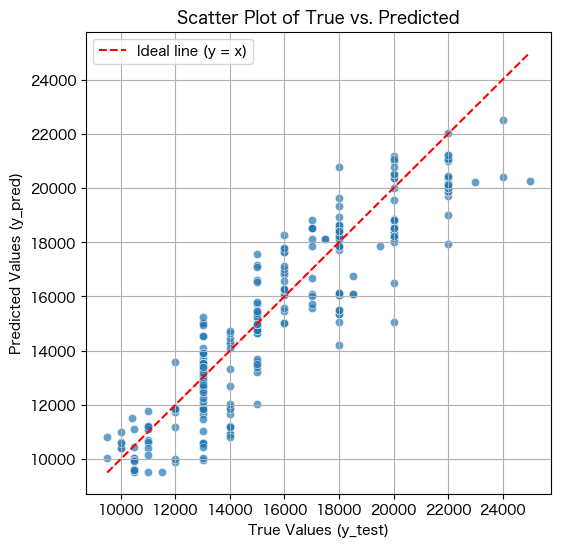

In [15]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_low'].values, y=y_test['price_low'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()


# RandomForest

In [16]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===========================================
# 1) データの読み込み
# ===========================================
# df = pd.read_csv('your_data.csv') などで読み込む想定
# 以下はサンプルとして df が既にある体で進めます

# 例: カラムが下記のようにあると想定
# 'tree_species', 'diameter_class', 'length', 'top_diameter_min', 'top_diameter_max',
# 'price_low', 'price_high', 'date', 'shipped_volume', など

# ===========================================
# 2) 前処理・欠損処理
# ===========================================
# (A) price_low, price_high が欠損の行を除外
df = df.dropna(subset=['price_low', 'price_high'])

# (B) 日付を datetime 型に変換して年・月を作成 (季節性の特徴量)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# 必要に応じて日付が NaT になった行を除外
df = df.dropna(subset=['year', 'month'])

# ===========================================
# 3) 特徴量と目的変数の定義
# ===========================================
# 今回は例として以下を入力特徴量にします
#   - 数値列: ['length', 'top_diameter_min', 'top_diameter_max',
#              'shipped_volume', 'year', 'month']
#   - カテゴリ列: ['tree_species', 'diameter_class']
# テキスト列(tone, summary)などは今回は使用せず

num_cols = ['length', 'top_diameter_min', 'top_diameter_max',
            'shipped_volume', 'year', 'month']
cat_cols = ['tree_species', 'diameter_class']

# 説明変数 (X) と目的変数 (y)
X = df[num_cols + cat_cols].copy()
y = df[['price_low', 'price_high']].copy()

# ===========================================
# 4) パイプライン作成 (前処理 -> モデル)
# ===========================================
# (A) 数値列のパイプライン
# - 欠損値を中央値で補完
# - 必要なら対数変換や標準化を入れる
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())    # 必要であれば標準化
])

# (B) カテゴリ列のパイプライン
# - 欠損値を最頻値で補完
# - One-Hot エンコーディング
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# (C) 列ごとの処理をまとめる
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

# (D) 回帰モデル (ランダムフォレスト) を MultiOutputRegressor で包む
#     → price_low, price_high を同時に予測
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# (E) 全体のパイプライン
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# ===========================================
# 5) 学習データとテストデータに分割
# ===========================================
# 時系列を意識するなら shuffle=False にして過去→未来の分割にするなど調整してください
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)  # 今は時系列を意識しないようにしている
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)  # 今は時系列を意識する

# ===========================================
# 6) モデル学習
# ===========================================
pipeline.fit(X_train, y_train)

# ===========================================
# 7) 予測 & 評価
# ===========================================
y_pred = pipeline.predict(X_test)

# y_pred は (N行, 2列) の numpy 配列 (price_low予測値, price_high予測値)
pred_low = y_pred[:, 0]
pred_high = y_pred[:, 1]

true_low = y_test['price_low'].values
true_high = y_test['price_high'].values

# MAE
mae_low = mean_absolute_error(true_low, pred_low)
mae_high = mean_absolute_error(true_high, pred_high)

print("MAE (low) :", mae_low)
print("MAE (high):", mae_high)

# RMSE
rmse_low = mean_squared_error(true_low, pred_low)
rmse_high = mean_squared_error(true_high, pred_high)

print("RMSE (low) :", rmse_low)
print("RMSE (high):", rmse_high)

MAE (low) : 1355.122255489022
MAE (high): 1386.7105788423153
RMSE (low) : 3342019.941866267
RMSE (high): 3330544.497671324


In [17]:
X_train

,length,top_diameter_min,top_diameter_max,shipped_volume,year,month,tree_species,diameter_class
6,4.0,18.0,24.0,850.0,1993,7,ヒノキ,中目
7,4.0,14.0,16.0,850.0,1993,7,ヒノキ,土台
12,4.0,18.0,22.0,650.0,1997,6,スギ,中目
13,4.0,24.0,30.0,650.0,1997,6,スギ,中目
14,3.0,14.0,18.0,650.0,1997,6,スギ,柱
...,...,...,...,...,...,...,...,...
7929,6.0,16.0,20.0,1500.0,2023,10,スギ,柱
7931,3.0,16.0,20.0,1500.0,2023,10,ヒノキ,柱
7932,6.0,16.0,20.0,1500.0,2023,10,ヒノキ,柱
7933,4.0,18.0,24.0,1500.0,2023,10,ヒノキ,中目


In [18]:
X_test

,length,top_diameter_min,top_diameter_max,shipped_volume,year,month,tree_species,diameter_class
7935,4.0,14.0,16.0,1500.0,2023,10,ヒノキ,土台
7937,4.0,18.0,24.0,2900.0,2023,10,スギ,中目
7938,4.0,24.0,30.0,2900.0,2023,10,スギ,中目
7939,3.0,16.0,20.0,2900.0,2023,10,スギ,柱
7940,6.0,16.0,20.0,2900.0,2023,10,スギ,柱
...,...,...,...,...,...,...,...,...
8342,3.0,16.0,20.0,1600.0,2025,2,ヒノキ,柱
8343,6.0,16.0,20.0,1600.0,2025,2,ヒノキ,柱
8344,4.0,18.0,24.0,1600.0,2025,2,ヒノキ,中目
8345,4.0,24.0,30.0,1600.0,2025,2,ヒノキ,中目


## 時系列を考慮して， train:test 分割を 0.05 にした場合

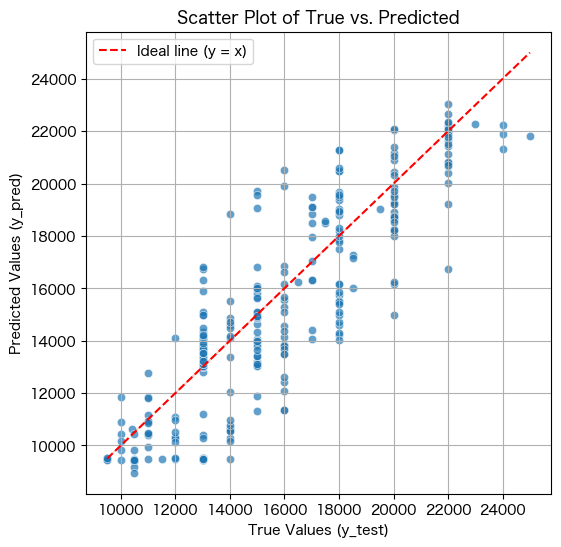

In [19]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_low'].values, y=y_test['price_low'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()


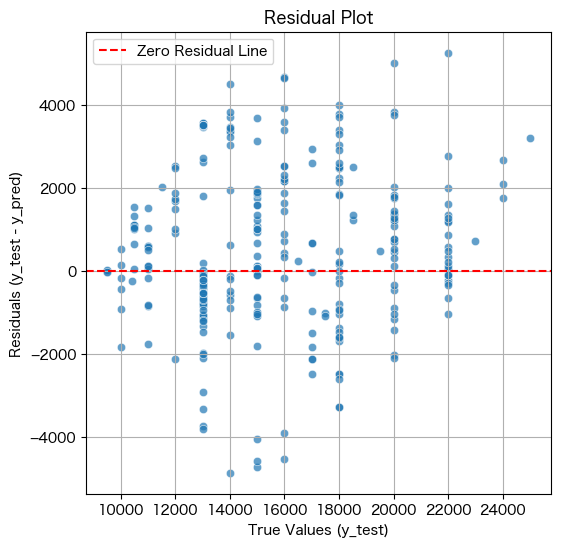

In [20]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=residuals.values[:,0], alpha=0.7)
plt.axhline(0, color="red", linestyle="--", label="Zero Residual Line")
plt.xlabel("True Values (y_test)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot")
plt.legend()
plt.grid()
plt.show()

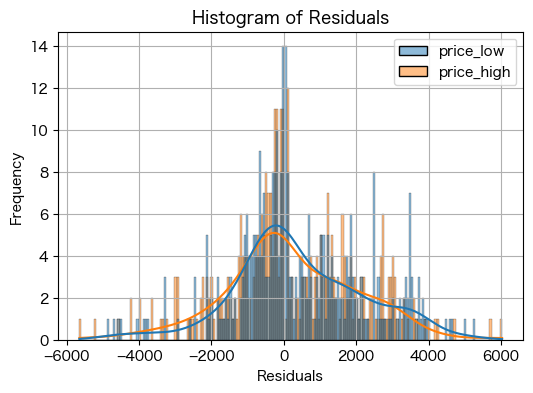

In [21]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=200, kde=True, edgecolor="black")
# plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid()
plt.show()

## 時系列を無視して Shuffle した場合（未来の時系列を使う）

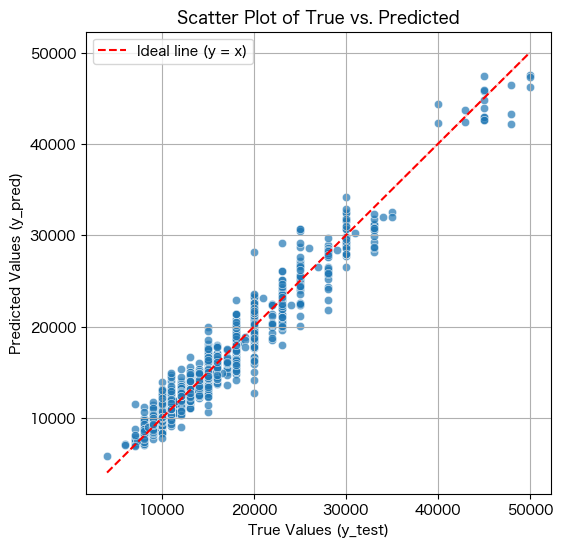

In [184]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_low'].values, y=y_test['price_low'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()


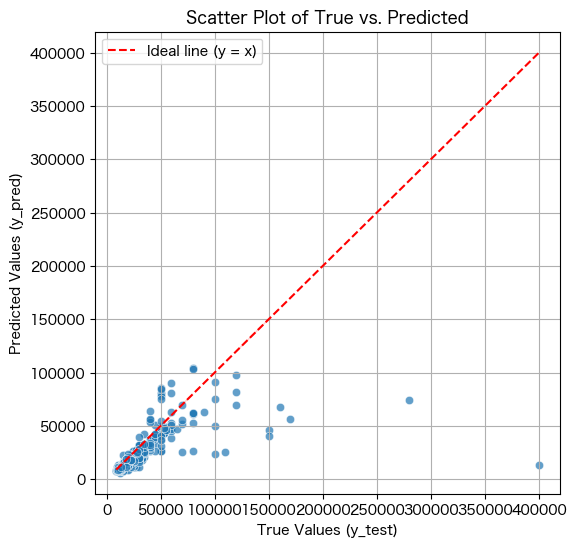

In [111]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_high'].values, y=y_pred[:, 0], alpha=0.7)
sns.lineplot(x=y_test['price_high'].values, y=y_test['price_high'].values, color="red", linestyle="--", label="Ideal line (y = x)")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of True vs. Predicted")
plt.legend()
plt.grid()
plt.show()

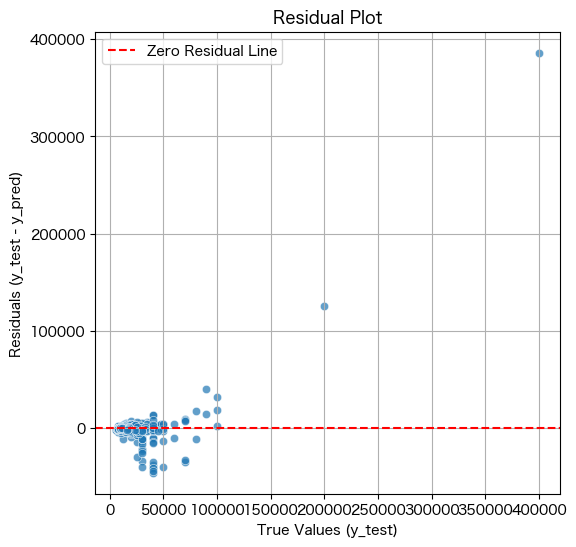

In [118]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test['price_low'].values, y=residuals.values[:,0], alpha=0.7)
plt.axhline(0, color="red", linestyle="--", label="Zero Residual Line")
plt.xlabel("True Values (y_test)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot")
plt.legend()
plt.grid()
plt.show()

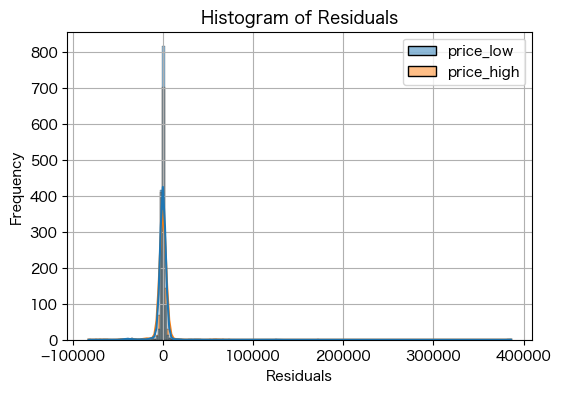

In [129]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=200, kde=True, edgecolor="black")
# plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.grid()
plt.show()

In [126]:
(residuals>0)['price_low'].value_counts()

price_low
False    724
True     709
Name: count, dtype: int64